In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# Read csv files

In [2]:
raw_wait_time_df = pd.read_csv("../data/real_wait_time_data.csv")

In [3]:
# check format of columns
raw_wait_time_df.info()
raw_wait_time_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111140 entries, 0 to 111139
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Park       111140 non-null  object
 1   Date/Time  111140 non-null  object
 2   Wait Time  111140 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


,Park,Date/Time,Wait Time
0,Universal Studios Singapore,2023-01-02T11:00:00Z,5
1,Universal Studios Singapore,2023-01-02T11:05:00Z,5
2,Universal Studios Singapore,2023-01-02T11:10:00Z,6
3,Universal Studios Singapore,2023-01-02T11:15:00Z,8
4,Universal Studios Singapore,2023-01-02T11:20:00Z,12


Below, we extract several information from the Date/Time column.

In [4]:
# extract date and time from Date/Time column
raw_wait_time_df['Date/Time'] = pd.to_datetime(raw_wait_time_df['Date/Time'])

wait_time_df = pd.DataFrame() # initialise df
wait_time_df['datetime'] = raw_wait_time_df['Date/Time']
wait_time_df['year'] = raw_wait_time_df['Date/Time'].dt.year
wait_time_df['month'] = raw_wait_time_df['Date/Time'].dt.month
wait_time_df['day_of_week'] = raw_wait_time_df['Date/Time'].dt.dayofweek + 1 # 1 for Monday
wait_time_df['date'] = pd.to_datetime(raw_wait_time_df['Date/Time'].dt.date)
wait_time_df['time'] = raw_wait_time_df['Date/Time'].dt.time
wait_time_df['hour'] = raw_wait_time_df['Date/Time'].dt.hour
wait_time_df['wait_time'] = raw_wait_time_df['Wait Time']

wait_time_df = wait_time_df.drop_duplicates()
wait_time_df = wait_time_df.sort_values(by='datetime')
wait_time_df.info()
wait_time_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 55570 entries, 0 to 50809
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   datetime     55570 non-null  datetime64[ns, UTC]
 1   year         55570 non-null  int32              
 2   month        55570 non-null  int32              
 3   day_of_week  55570 non-null  int32              
 4   date         55570 non-null  datetime64[ns]     
 5   time         55570 non-null  object             
 6   hour         55570 non-null  int32              
 7   wait_time    55570 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int32(4), int64(1), object(1)
memory usage: 3.0+ MB


,datetime,year,month,day_of_week,date,time,hour,wait_time
0,2023-01-02 11:00:00+00:00,2023,1,1,2023-01-02,11:00:00,11,5
1,2023-01-02 11:05:00+00:00,2023,1,1,2023-01-02,11:05:00,11,5
2,2023-01-02 11:10:00+00:00,2023,1,1,2023-01-02,11:10:00,11,6
3,2023-01-02 11:15:00+00:00,2023,1,1,2023-01-02,11:15:00,11,8
4,2023-01-02 11:20:00+00:00,2023,1,1,2023-01-02,11:20:00,11,12


Note that day_of_week = 1 for Monday, 7 for Sunday.

# Simple analysis

This section does simple analysis (not time analysis) of the wait time, to generate synthetic data.

Below, we plot the wait time distribution for one day.

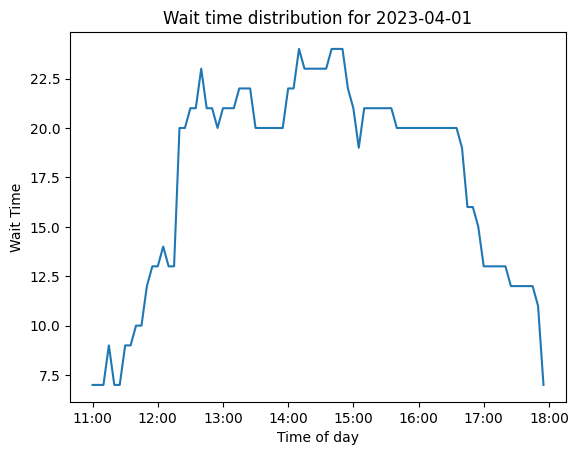

In [5]:
# wait time distribution for one day
chosen_date = '2023-04-01'
sample_date = wait_time_df[wait_time_df['date']==chosen_date]

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(sample_date['datetime'],sample_date['wait_time'])
plt.xlabel("Time of day")
plt.ylabel("Wait Time")
plt.title(f"Wait time distribution for {chosen_date}")
plt.show()

In [6]:
# look at which months & years we have
month_year = wait_time_df[['year', 'month']].drop_duplicates()
month_year = month_year.sort_values(by=['year', 'month'])
for _, row in month_year.iterrows():
    print(f"{row['month']}\t{row['year']}")

1	2023
2	2023
3	2023
4	2023
5	2023
6	2023
7	2023
8	2023
9	2023
10	2023
11	2023
12	2023
1	2024
2	2024
3	2024
4	2024
5	2024
6	2024
7	2024
8	2024
9	2024
10	2024


In [7]:
# the earliest and latest time stamps
earliest_time = wait_time_df['time'].min()
latest_time = wait_time_df['time'].max()

print(f"Earliest time: {earliest_time}")
print(f"Latest time: {latest_time}")

# the earliest date
earliest_date = wait_time_df['date'].min()
print(f"Earliest date: {earliest_date}")

Earliest time: 08:00:00
Latest time: 23:50:00
Earliest date: 2023-01-02 00:00:00


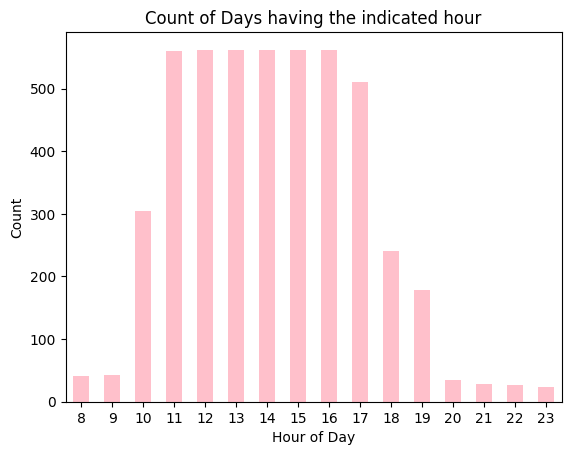

In [8]:
unique_hour_counts = wait_time_df.groupby(['date', 'hour']).size().reset_index(name='counts')

hour_counts = unique_hour_counts['hour'].value_counts().sort_index()
hour_counts.plot(kind='bar', color='pink')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Count of Days having the indicated hour')
plt.xticks(rotation=0)
plt.show()

The official park opening hours is 1000-1700.

As seen above, there are days where there are timings after 1700 and before 1000. As for timings after 1700, it is possible that these are during the months of September and October when Halloween Horror Nights happens, as the park is open from 1915-2359.

For synthetic wait time generation below, we will be generating data for 0800-2359.

## Patterns

1. Daily Pattern (Within a Day - Peak Hours)
2. Weekly Pattern (Within a Week)
3. Seasonal Pattern (Within a Year)

Daily pattern

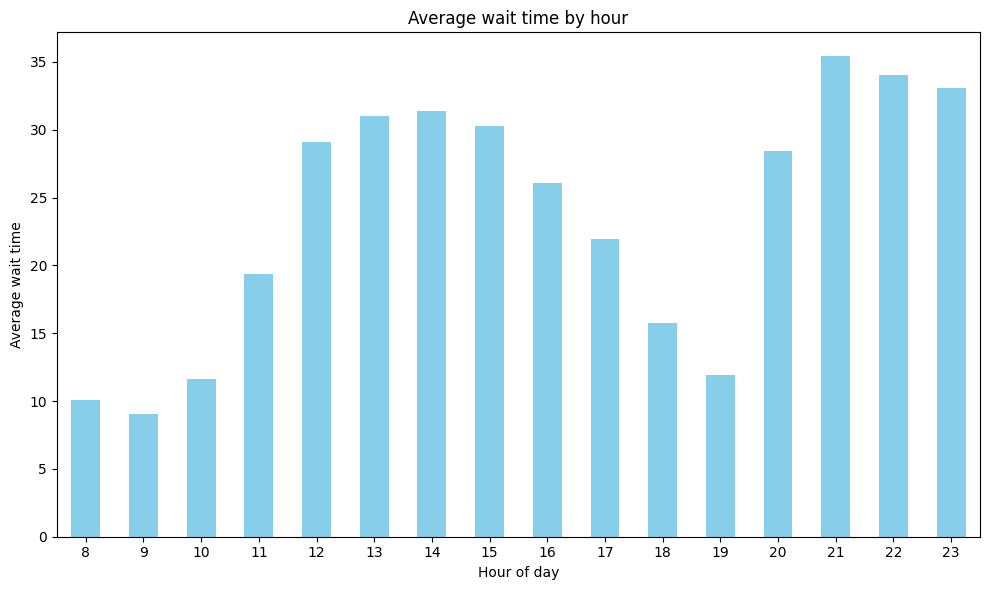

In [9]:
daily_pattern = wait_time_df.groupby('hour')['wait_time'].mean()

plt.figure(figsize=(10, 6))
daily_pattern.plot(kind='bar', color='skyblue')
plt.title('Average wait time by hour')
plt.xlabel('Hour of day')
plt.ylabel('Average wait time')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Peak hours: 1200 to 1555, 2000-2355

Mid-peak hours: 1100-1155, 1600-1755

Off-peak hours: 0800-1055, 1800-1955

Weekly pattern

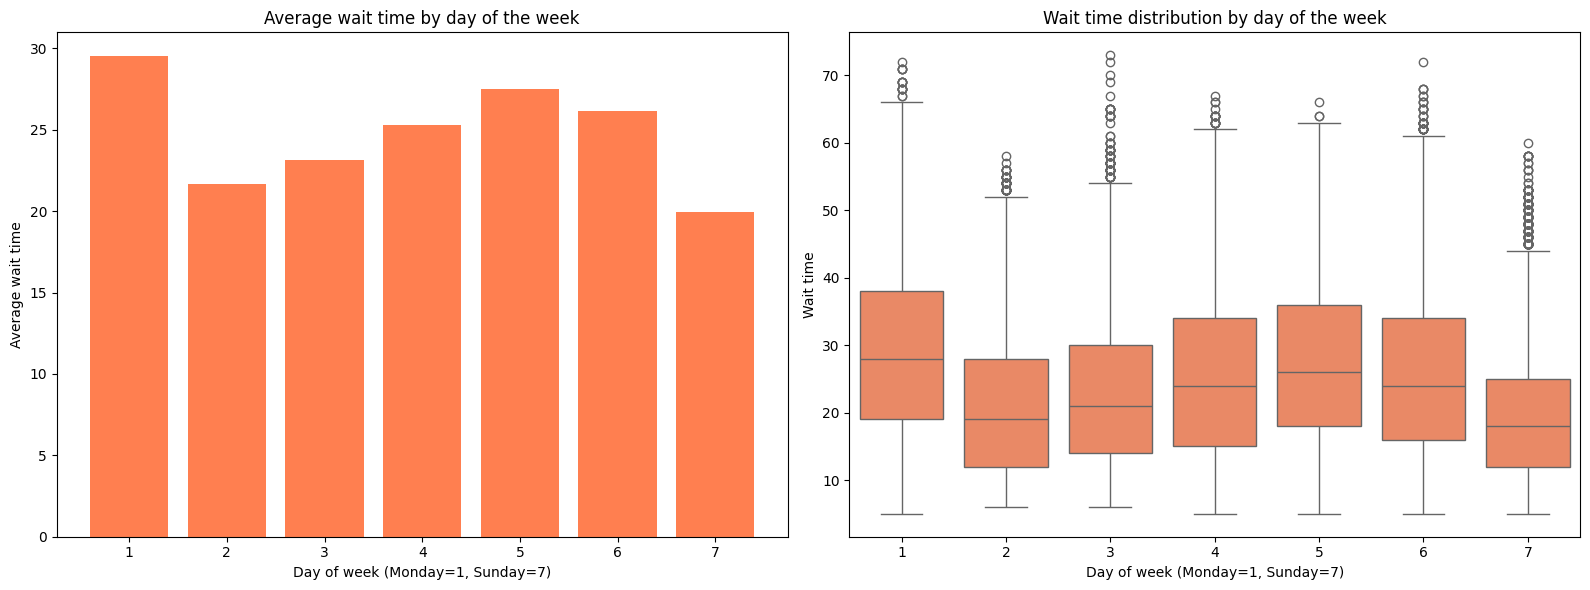

In [10]:
weekly_pattern = wait_time_df.groupby('day_of_week')['wait_time'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# bar plot
axes[0].bar(weekly_pattern.index, weekly_pattern.values, color='coral')
axes[0].set_title('Average wait time by day of the week')
axes[0].set_xlabel('Day of week (Monday=1, Sunday=7)')
axes[0].set_ylabel('Average wait time')
axes[0].set_xticks(weekly_pattern.index)
axes[0].set_xticklabels(weekly_pattern.index)

# box plot
sns.boxplot(data=wait_time_df, x='day_of_week', y='wait_time', color='coral', ax=axes[1])
axes[1].set_title('Wait time distribution by day of the week')
axes[1].set_xlabel('Day of week (Monday=1, Sunday=7)')
axes[1].set_ylabel('Wait time')

plt.tight_layout()
plt.show()

Peak days: Mon, Thurs, Fri, Sat

Off-peak days: Tues, Wed, Sun

Seasonal pattern

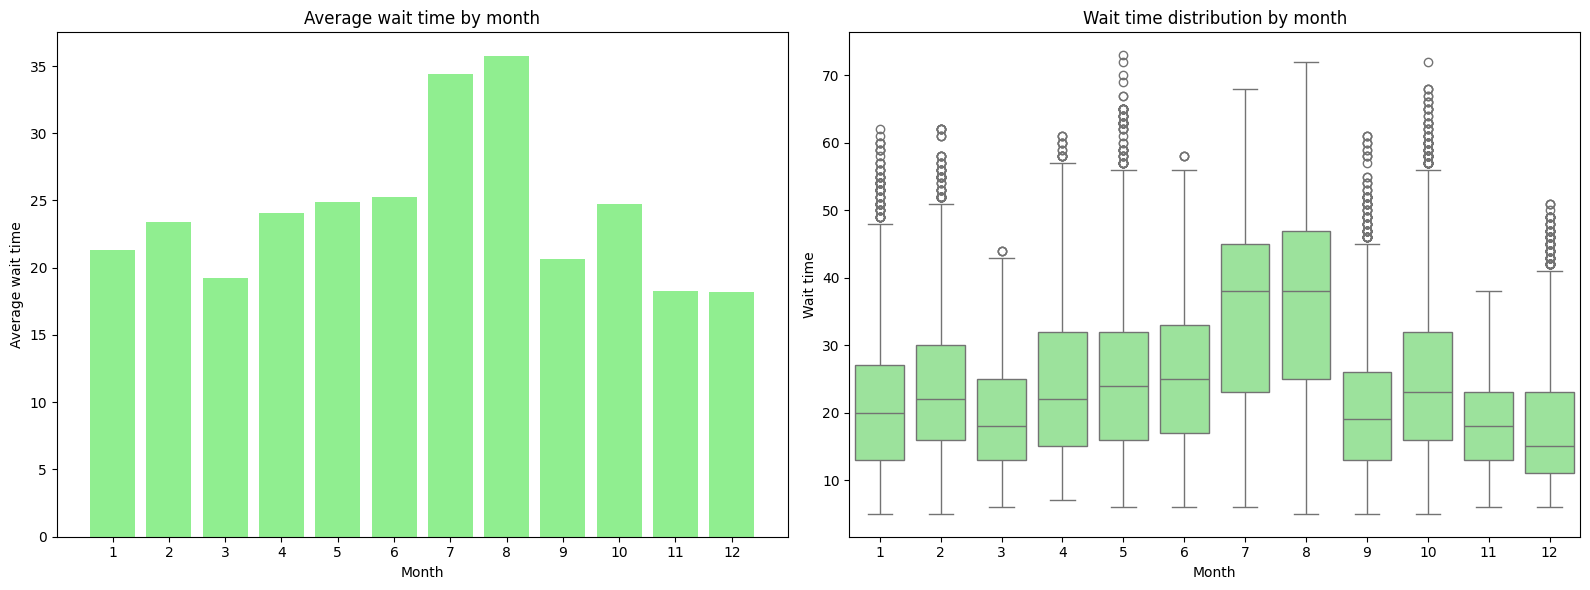

In [16]:
seasonal_pattern = wait_time_df.groupby('month')['wait_time'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# bar plot
axes[0].bar(seasonal_pattern.index, seasonal_pattern.values, color='lightgreen')
axes[0].set_title('Average wait time by month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average wait time')
axes[0].set_xticks(seasonal_pattern.index)
axes[0].set_xticklabels(seasonal_pattern.index)

# box plot
sns.boxplot(data=wait_time_df, x='month', y='wait_time', color='lightgreen', ax=axes[1])
axes[1].set_title('Wait time distribution by month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Wait time')

plt.tight_layout()
plt.show()


Peak months: July, Aug

Mid-peak months: Jan-Feb, Apr-June, Oct

Off-peak months: Mar, Sep, Nov, Dec

# Generate synthetic wait time data for Jan 2019 to Dec 2022.

In [66]:
# Step 1: Generate the datetime range from 2019-01-01 to 2022-12-31, between 0800 to 2350 at 5-minute intervals
def generate_date_range(start_year, end_year):
    date_range = []
    current_date = datetime(start_year, 1, 1, 8, 0) # earliest time 0800
    end_date = datetime(end_year, 12, 31, 23, 50) # latest time 2350
    
    while current_date <= end_date:
        if current_date.time() >= datetime(2023, 1, 1, 8, 0).time() and current_date.time() <= datetime(2023, 1, 1, 23, 50).time():
            date_range.append(current_date)
        current_date += timedelta(minutes=5)
    
    return date_range

# Generate datetime range
datetime_range = generate_date_range(2019, 2022)

In [67]:
# based on the pattern analysis done above

def daily_pattern(hour):
    # Peak hours: 1200 to 1555, 2000-2355
    # Mid-peak hours: 1100-1155, 1600-1755
    # Off-peak hours: 0800-1055, 1800-1955
    if 8 <= hour <= 10 or 18 <= hour <= 19:
        return 0.4 # off-peak
    elif 12 <= hour <= 15 or 20 <= hour <= 23:
        return 1.4 # peak hour
    return 0.9  # mid-peak

def weekly_pattern(day_of_week):
    # Peak days: Mon, Thurs, Fri, Sat
    # Off-peak days: Tues, Wed, Sun
    if day_of_week in [1,4,5,6]:
        return 1.2 # busy
    return 0.85

def seasonal_pattern(month):
    # Simulate busier seasons (e.g., summer months, holidays)
    if month in [7, 8]:
        return 1.45 # peak months
    elif month in [3, 9, 11, 12]: 
        return 0.8 # off-peak months
    return 1.0  # mid-peak

In [68]:
wait_time_mean = wait_time_df['wait_time'].mean()
wait_time_std = wait_time_df['wait_time'].std()
print(f"Mean wait time: {wait_time_mean}")
print(f"Stdev wait time: {wait_time_std}")

Mean wait time: 24.844448443404715
Stdev wait time: 12.565276955381629


In [69]:
def simulate_wait_times(n, mean, std):
    return np.clip(np.random.normal(loc=mean, scale=std, size=n), 0, None)  # ensure non-negative wait times

wait_time_mean = wait_time_df['wait_time'].mean()
wait_time_std = wait_time_df['wait_time'].std()
synthetic_wait_times = []

for dt in datetime_range:
    base_wait_time = simulate_wait_times(1, wait_time_mean, wait_time_std)[0]
    
    # Apply patterns
    daily_adjustment = daily_pattern(dt.hour)
    weekly_adjustment = weekly_pattern(dt.weekday())
    seasonal_adjustment = seasonal_pattern(dt.month)
    
    # Adjust the base wait time by these patterns
    adjusted_wait_time = base_wait_time * daily_adjustment * weekly_adjustment * seasonal_adjustment
    synthetic_wait_times.append(adjusted_wait_time)

In [70]:
synthetic_data = {
    'datetime': datetime_range,
    'year': [dt.year for dt in datetime_range],
    'month': [dt.month for dt in datetime_range],
    'day_of_week': [dt.weekday() for dt in datetime_range],
    'date': [dt.date() for dt in datetime_range],
    'time': [dt.time() for dt in datetime_range],
    'hour': [dt.hour for dt in datetime_range],
    'wait_time': synthetic_wait_times
}

synthetic_df = pd.DataFrame(synthetic_data)

# smoothen out wait times using moving average
# min_periods=1 prevents NaN values

window_size = 5
synthetic_df['smoothed_wait_time'] = (synthetic_df['wait_time'].rolling(window=window_size, min_periods=1).mean())

# change to the same datatypes
synthetic_df['datetime'] = synthetic_df['datetime'].dt.tz_localize('UTC')

synthetic_df['year'] = synthetic_df['year'].astype('int32')
synthetic_df['month'] = synthetic_df['month'].astype('int32')
synthetic_df['day_of_week'] = synthetic_df['day_of_week'].astype('int32')
synthetic_df['hour'] = synthetic_df['hour'].astype('int32')
synthetic_df['date'] = pd.to_datetime(synthetic_df['date'])

# Show the first few rows of the synthetic data
print(synthetic_df.head())
print(synthetic_df.info())

                   datetime  year  month  day_of_week       date      time  \
0 2019-01-01 08:00:00+00:00  2019      1            1 2019-01-01  08:00:00   
1 2019-01-01 08:05:00+00:00  2019      1            1 2019-01-01  08:05:00   
2 2019-01-01 08:10:00+00:00  2019      1            1 2019-01-01  08:10:00   
3 2019-01-01 08:15:00+00:00  2019      1            1 2019-01-01  08:15:00   
4 2019-01-01 08:20:00+00:00  2019      1            1 2019-01-01  08:20:00   

   hour  wait_time  smoothed_wait_time  
0     8   4.811107            4.811107  
1     8  20.246957           12.529032  
2     8   0.000000            8.352688  
3     8  17.662113           10.680044  
4     8  19.898423           12.523720  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279051 entries, 0 to 279050
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   datetime            279051 non-null  datetime6

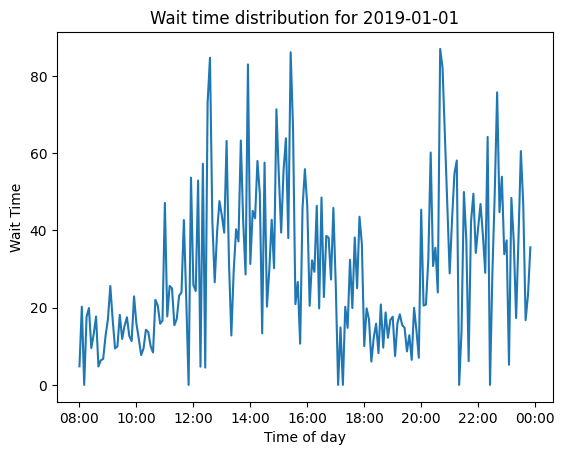

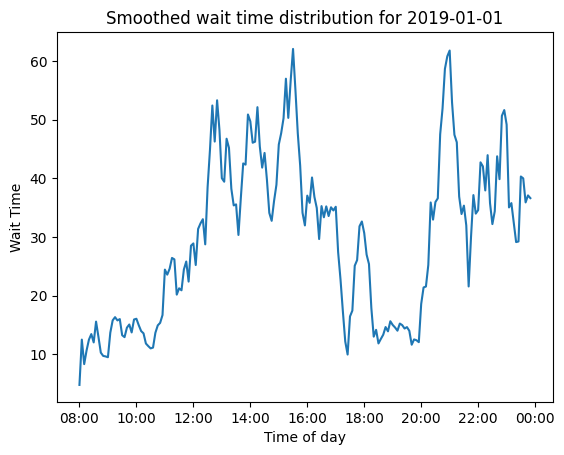

In [71]:
# wait time distribution for one day
# compare original and smoothened wait times
chosen_date = '2019-01-01'
sample_date = synthetic_df[synthetic_df['date']==chosen_date]

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(sample_date['datetime'],sample_date['wait_time'])
plt.xlabel("Time of day")
plt.ylabel("Wait Time")
plt.title(f"Wait time distribution for {chosen_date}")
plt.show()

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(sample_date['datetime'],sample_date['smoothed_wait_time'])
plt.xlabel("Time of day")
plt.ylabel("Wait Time")
plt.title(f"Smoothed wait time distribution for {chosen_date}")
plt.show()

In [72]:
# replace noisy wait time with smoothed_wait_time
smoothened_synthetic_df = synthetic_df.copy()
smoothened_synthetic_df['wait_time'] = synthetic_df['smoothed_wait_time']
smoothened_synthetic_df = smoothened_synthetic_df.drop(columns=['smoothed_wait_time'])

# combine synthetic data with real data
combined_wait_time_df = pd.concat([smoothened_synthetic_df, wait_time_df]).sort_values(by='datetime')

In [73]:
combined_wait_time_df.head()

,datetime,year,month,day_of_week,date,time,hour,wait_time
0,2019-01-01 08:00:00+00:00,2019,1,1,2019-01-01,08:00:00,8,4.811107
1,2019-01-01 08:05:00+00:00,2019,1,1,2019-01-01,08:05:00,8,12.529032
2,2019-01-01 08:10:00+00:00,2019,1,1,2019-01-01,08:10:00,8,8.352688
3,2019-01-01 08:15:00+00:00,2019,1,1,2019-01-01,08:15:00,8,10.680044
4,2019-01-01 08:20:00+00:00,2019,1,1,2019-01-01,08:20:00,8,12.523720


In [74]:
# save as csv file
combined_wait_time_df.to_csv('combined_wait_time_df.csv', index=False)